## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import re

import torch

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
from random import sample
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-11-14 17:47:57--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2024-11-14 17:47:58 (4.65 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

AssertionError: Are you sure you have concatenated all the strings?

### Data loading: "Евгений Онегин"


In [ ]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
text[:15]

['\n',
 'I\n',
 '\n',
 '«Мой дядя самых честных правил,\n',
 'Когда не в шутку занемог,\n',
 'Он уважать себя заставил\n',
 'И лучше выдумать не мог.\n',
 'Его пример другим наука;\n',
 'Но, боже мой, какая скука\n',
 'С больным сидеть и день и ночь,\n',
 'Не отходя ни шагу прочь!\n',
 'Какое низкое коварство\n',
 'Полуживого забавлять,\n',
 'Ему подушки поправлять,\n',
 'Печально подносить лекарство,\n']

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = " ".join(text).lower()
text[:100]

'\n i\n \n «мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше'

In [ ]:
def clean_text(text):
    # Удаляем "римские цифры" между двумя переносами строки
    text = re.sub(r'\n\s*[ivxlcdm]+\s*\n', '\n\n', text)
    # Оставляем только буквы русского и английского алфавитов, цифры, пробелы, знаки препинания и переводы строк
    # text = re.sub(r'[^\w\s.,!?;:\-\(\)а-яА-ЯёЁ]', '', text)
    text = re.sub(r'[a-zA-Z0-9]+', '', text)  # Убираем все английские слова и цифры
    return text

text = clean_text(text)
print(text[:100])



 «мой дядя самых честных правил,
 когда не в шутку занемог,
 он уважать себя заставил
 и лучше выд


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))

tokens.append('_') # <PAD>
num_tokens = len(tokens)

consts= {
    'num_tokens': num_tokens
}

consts['num_tokens']

55

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
idx2char = {i: c for i, c in enumerate(tokens)}

# dict <char>:<index>
char2idx = {c: i for i, c in enumerate(tokens)}

In [ ]:
seq_length = 100
sentences = []
next_chars = []

for i in range(0, len(text) - seq_length):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])

sentences = np.array(sentences)
next_chars = np.array(next_chars)

print(sentences[:5])
print(next_chars[:5])
print('Number of sequences:', len(sentences))
print(sentences.shape, next_chars.shape)

['\n\n «мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выд'
 '\n «мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выду'
 ' «мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выдум'
 '«мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выдума'
 'мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выдумат']
['у' 'м' 'а' 'т' 'ь']
Number of sequences: 143942
(143942,) (143942,)


Переводим в индексы для обучения

In [ ]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences), seq_length))
    y = np.zeros((len(sentences)))

    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char2idx[char]
        y[i] = char2idx[next_chars[i]]
    return X, y

In [ ]:
train_x, train_y = getdata(sentences, next_chars)
print('Shape of train_x:', train_x.shape)
print('Shape of train_y:', train_y.shape)

Shape of train_x: (143942, 100)
Shape of train_y: (143942,)


формируем обуч. выборку

In [ ]:
# в тензоры
X_train = torch.tensor(train_x, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)

In [ ]:
from torch.utils.data import DataLoader

train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

### Building the model (base RNN можно сказать ручками)

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [103]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens, embedding_size, rnn_num_units):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size, device=device)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units, device=device)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens, device=device)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)

        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits


    def initial_state(self, batch_size=100):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True, device=device)

In [104]:
char_rnn = CharRNNCell(consts['num_tokens'], embedding_size=64, rnn_num_units=128)
hid_state0 = char_rnn.initial_state()
hid_state0.shape

torch.Size([100, 128])

RNN LOOP

In [105]:
def rnn_loop(char_rnn, batch):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)

    return torch.stack(logits, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

The training loop

In [106]:
char_rnn = CharRNNCell(num_tokens, embedding_size=64, rnn_num_units=128)
hid_state0 = char_rnn.initial_state()


opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=char2idx['_'])

history = []

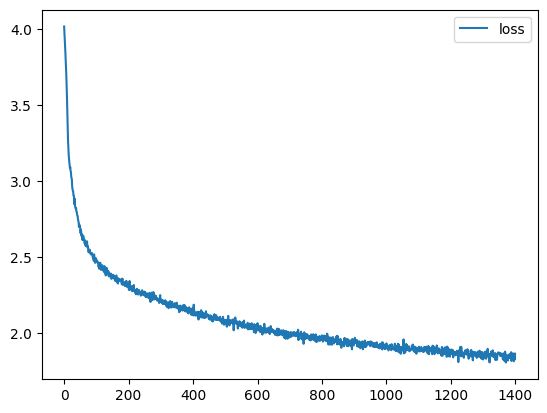

CPU times: user 1min 15s, sys: 1.54 s, total: 1min 16s
Wall time: 1min 17s


In [107]:
%%time
for i, data in enumerate(train_loader):
    batch = data[0]
    logits_seq = rnn_loop(char_rnn, batch)


    # Likelihood and gradients
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch[:, 1:]

    loss = loss_func(
        predictions_logits.reshape((-1, num_tokens)),
        actual_next_tokens.reshape(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.detach().cpu().numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [109]:
# обобщение предыдущего цикла обучения в одну эпоху, теперь можем делать несколько таких эпох чтобы повысить качество обучения
def train(model, num_epochs):
    history = []

    for epoch in range(num_epochs):
        train_loss = 0

        for i, data in enumerate(train_loader):
            batch = data[0]
            logits_seq = rnn_loop(model, batch)


            predictions_logits = logits_seq[:, :-1]
            actual_next_tokens = batch[:, 1:]

            loss = loss_func(
                predictions_logits.reshape((-1, num_tokens)),
                actual_next_tokens.reshape(-1)
            )

            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.detach().cpu().numpy()

        train_loss /= len(train_loader)
        history.append(train_loss)

        print(f"Epoch {epoch + 1} of {num_epochs}", end='')
        print(f"  train loss: {train_loss:.3f}")\

    return model, history

In [110]:
%%time
# по факту обучили 1+5 эпох, поэтому лосс тут стартует уже с 1.7
char_rnn_trained, history_loss = train(char_rnn, 5)

Epoch 1 of 5  train loss: 1.773
Epoch 2 of 5  train loss: 1.692
Epoch 3 of 5  train loss: 1.648
Epoch 4 of 5  train loss: 1.620
Epoch 5 of 5  train loss: 1.600
CPU times: user 6min 10s, sys: 975 ms, total: 6min 11s
Wall time: 6min 34s


In [112]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=500, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [char2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):

        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out.detach().cpu() / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [113]:
print(generate_sample(char_rnn_trained, seed_phrase=' мой дядя самых честных правил\n когда не в шутку занемог,\n он у',
                      max_length=500, temperature=0.2))

 мой дядя самых честных правил
 когда не в шутку занемог,
 он устах соседом страха,
 с ней не всех под приятный проста
 он в после был покой постеленный,
 и в сердце простор забоконы
 привычки в поле, привется столо,
 как на свои страстей старины,
 и всех странный полей в том.
 простите сердце в сердечный своей
 приятно благословенный своей
 приятно ульянам столе
 татьяна страсти в сердцем конец
 ответ долго посланье,
 под ней сердце в сердце своей сосед
 и не послушает страстей отрада,
 и в себ


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [114]:
for data, y in train_loader:
    a1 = data
    b1 = y
    break
print(a1.shape, b1.shape)

torch.Size([100, 100]) torch.Size([100])


In [115]:
class Simple_LSTM(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, dropout=0.2, seq_length=100):
        super(Simple_LSTM, self).__init__()
        torch.manual_seed(0)
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.seq_length_to_fit = seq_length

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout, num_layers=2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)

    def forward(self, seq_in, printt=False):
        embedded = self.embeddings(seq_in)
        if printt:
            print('after emb', embedded.shape)

        lstm_out, _ = self.lstm(embedded)
        if printt:
            print('after lstm', lstm_out.shape)

        ht = lstm_out[:, -1]
        if printt:
            print('after agg', ht.shape)

        logits = self.fc(ht)
        return logits

In [116]:
hyper_parametrs = {
    'seq_length': 100,
    'embedding_dim': 64,
    'hidden_dim': 128
}

In [117]:
model = Simple_LSTM(n_vocab=consts['num_tokens'],
                    hidden_dim=hyper_parametrs['hidden_dim'],
                    embedding_dim=hyper_parametrs['embedding_dim'],
                    dropout=0.2,
                    seq_length=hyper_parametrs['seq_length'])
model = model.to(device)
model

Simple_LSTM(
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (embeddings): Embedding(55, 64)
  (fc): Linear(in_features=128, out_features=55, bias=True)
)

In [118]:
out = model(a1, printt=True)
out.shape

after emb torch.Size([100, 100, 64])
after lstm torch.Size([100, 100, 128])
after agg torch.Size([100, 128])


torch.Size([100, 55])

In [119]:
def train(model, crit, optim,
          train_loader,
          num_epochs=10,
          plot=False):

    history = {'loss': []}

    for epoch in range(num_epochs):
        train_loss = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optim.zero_grad()

            outputs = model(inputs)
            loss = crit(outputs, labels)

            loss.backward()
            optim.step()

            train_loss += np.sum(loss.detach().cpu().numpy())

        train_loss /= len(train_loader)
        history['loss'].append(train_loss)
        print(f"Epoch {epoch + 1} of {num_epochs}", end='')
        print(f"  train loss: {train_loss:.3f}")

    return model, history

In [120]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['_'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_trained, history = train(
    model, criterion, optimizer,
    train_loader,
    num_epochs=30,
)

Epoch 1 of 30  train loss: 2.476
Epoch 2 of 30  train loss: 2.149
Epoch 3 of 30  train loss: 2.025
Epoch 4 of 30  train loss: 1.946
Epoch 5 of 30  train loss: 1.884
Epoch 6 of 30  train loss: 1.837
Epoch 7 of 30  train loss: 1.797
Epoch 8 of 30  train loss: 1.761
Epoch 9 of 30  train loss: 1.733
Epoch 10 of 30  train loss: 1.709
Epoch 11 of 30  train loss: 1.686
Epoch 12 of 30  train loss: 1.665
Epoch 13 of 30  train loss: 1.646
Epoch 14 of 30  train loss: 1.631
Epoch 15 of 30  train loss: 1.615
Epoch 16 of 30  train loss: 1.599
Epoch 17 of 30  train loss: 1.588
Epoch 18 of 30  train loss: 1.573
Epoch 19 of 30  train loss: 1.563
Epoch 20 of 30  train loss: 1.553
Epoch 21 of 30  train loss: 1.543
Epoch 22 of 30  train loss: 1.530
Epoch 23 of 30  train loss: 1.521
Epoch 24 of 30  train loss: 1.513
Epoch 25 of 30  train loss: 1.505
Epoch 26 of 30  train loss: 1.495
Epoch 27 of 30  train loss: 1.491
Epoch 28 of 30  train loss: 1.481
Epoch 29 of 30  train loss: 1.473
Epoch 30 of 30  train l

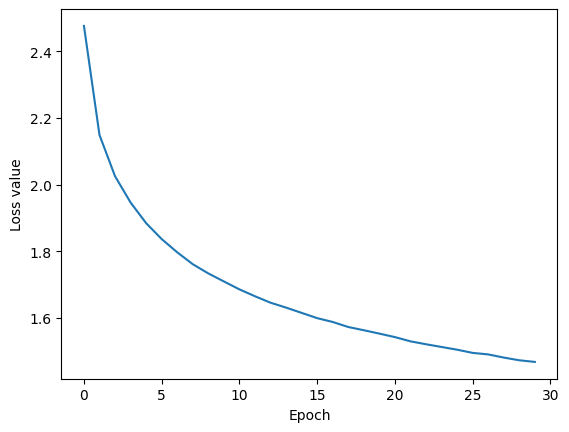

In [121]:
plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [122]:
def get_sample(preds, temperature=1.0):
    '''
    The function selects the next symbol based on the predicted probabilities
    :param preds: predicted probabilities
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    adjusted_probs = F.softmax(preds / temperature, dim=-1).cpu().detach().numpy()
    char_idx = np.random.choice(range(len(preds)), p=adjusted_probs)

    return char_idx

In [123]:
def generate_text(model, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least max_length.
    :param trained model
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    if seed_phrase is not None:
        x_sequence = [char2idx[token] for token in seed_phrase]
    else:
        x_sequence = []

    result = x_sequence
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64, device=device)
    x_sequence = x_sequence[None, :] # to match the dimensions of the tensors..

    # padding if seed is too short (need for fit)
    if len(seed_phrase) <= model.seq_length_to_fit:
        num_to_pad = model.seq_length_to_fit - len(seed_phrase)
        padding = torch.tensor([char2idx['_'] for _ in range(num_to_pad)], dtype=torch.int64, device=device)
        padding = padding[None, :]# to match the dimensions of the tensors..

        x_sequence =  torch.cat([padding, x_sequence], dim=-1)

    # sequentially fitting for all seed if it's longer then seq_length
    else:
        num_to_fit = len(seed_phrase)-model.seq_length_to_fit
        idx_seed_phrase = x_sequence
        for i in range(num_to_fit):
            x_sequence = idx_seed_phrase[:, i:50+i]
            logits = model(x_sequence)[0]

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits = model(x_sequence)[0]

        # sample next token
        next_char_index = get_sample(logits, temperature)
        result.append(next_char_index)

        # push it back into x_sequence
        next = torch.tensor([[next_char_index]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence[:, 1:], next], dim=-1)

    return ''.join([idx2char[idx] for idx in result])


In [124]:
sentence = ' мой дядя самых честных правил\n когда не в шутку занемог,\n он у'

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"[TEMP = {temp}]")
    print(generate_text(model_trained, seed_phrase=sentence, max_length=300, temperature=temp, device=device))

[TEMP = 0.1]
 мой дядя самых честных правил
 когда не в шутку занемог,
 он уж мой в сердца от сердце —
 «не всех полно в каками света,
 и страстей старинный полет
 и в молодом полно нашей —
 не светит и полу последний
 и в тени своей постепенный,
 и в поле не встали в ней дале,
 не знаю, старинный мой друзья,
 и
[TEMP = 0.2]
 мой дядя самых честных правил
 когда не в шутку занемог,
 он умолкнувший не постели
 и страстей полно волновал
 он в своей не полного стреметь,
 и в своей не под сонего ль
 на страстей не полного своей
 под ней нет не видит она.
 татьяна с ним и долго свой
 старик, и славы получил.
 он в том уж не 
[TEMP = 0.5]
 мой дядя самых честных правил
 когда не в шутку занемог,
 он уж не простительных взор
 и был порой от конце мой
 страстей полное томе вы?
 кто не стариком объяснели
 под ветреный мой как-нибудь
 под нем покойник на собою.
 в гором с очере в тени спит
 и заблечен и глупаю вновь;
 не могнится как и д
[TEMP = 1.0]
 мой дядя самых честных правил
 когда не в шу

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [125]:
PATH = "/content/trained_model.pt"

In [126]:
torch.save(model_trained.state_dict(), PATH)

In [127]:
the_model = Simple_LSTM(n_vocab=consts['num_tokens'],
                    hidden_dim=hyper_parametrs['hidden_dim'],
                    embedding_dim=hyper_parametrs['embedding_dim'],
                    dropout=0.2,
                    seq_length=hyper_parametrs['seq_length'])
the_model.load_state_dict(torch.load(PATH))
the_model = the_model.to(device)

<ipython-input-127-8b717c7bdfd9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  the_model.load_state_dict(torch.load(PATH))


In [128]:
sentence = ' мой дядя самых честных правил\n когда не в шутку занемог,\n он у'

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"[TEMP = {temp}]")
    print(generate_text(the_model, seed_phrase=sentence, max_length=300, temperature=temp, device=device))

[TEMP = 0.1]
 мой дядя самых честных правил
 когда не в шутку занемог,
 он увидеть молча подруги,
 и в ней не почтенный полею
 и в сад ней на воскривая,
 и в поле полеволенный мой
 и полны не поднять не поле,
 и в самом и поле не скучно
 и в нем он в сердца под нею света
 и под ней скоро свети нет.
 в то же в мо
[TEMP = 0.2]
 мой дядя самых честных правил
 когда не в шутку занемог,
 он уж не все друг меня свет.
 но везде заняться в дворей.

 все воточет и пора со стало,
 на старины в полу все полны,
 но скучал в девошный взгляда,
 в конца привычный взором,
 не постепенно своей дале,
 и в сад был по старый полотный,
 и в
[TEMP = 0.5]
 мой дядя самых честных правил
 когда не в шутку занемог,
 он уж мни не почтенный рон.

 но то не под как себя страхан;
 но верова, быть мой веками,
 с полиность не встали молчанье,
 и странный уголо все доли.
 в ней он полею почему
 была по красно возвращенный, —
 мне все как же вот под ней страсти
[TEMP = 1.0]
 мой дядя самых честных правил
 когда не в шу

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)